# Assignment 1

In [41]:
import os
import numpy as np
import matplotlib.pyplot as plt

## Task 1:  Appearance based classification (programming)

### Download the Cifar-10 dataset

In [5]:
data_dir = "data\cifar-10-batches-py"

### Read the first data batch

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [148]:
batch = unpickle(os.path.join(data_dir, "data_batch_1"))
data = np.asarray(batch[b'data'])  # (10000, 3072) numpy array of uint8
labels = np.asarray(batch[b'labels'])  # List of 10000 labels

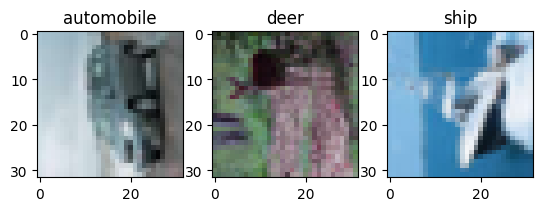

In [150]:
# Define the class labels we're interested in
target_labels = {1: 'automobile', 4: 'deer', 8: 'ship'}

def getNSamplesPerClass(targets, x, y, n):
    return {t: np.reshape(x[np.where(y==t)[0][:n]], (n, 32, 32, 3), order="F") for t in targets}

def plotRandomImages(targets, x):
    fig, axes = plt.subplots(ncols=len(targets))
    for ax, (i, name) in zip(axes, targets.items()):
        samples = x[i]
        ax.imshow(samples[np.random.choice(len(samples))])
        ax.set_title(name)
    plt.show()

class_images = getNSamplesPerClass(target_labels, data, labels, 30)
plotRandomImages(target_labels, class_images)

In [151]:
# Convert each image in class_images to grayscale by taking the mean over all color channels
grayscale_images = {label: [np.mean(img, axis=-1) for img in imgs] for label, imgs in class_images.items()}

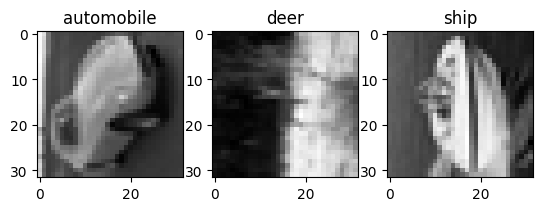

In [152]:
fig, axes = plt.subplots(ncols=len(target_labels))
for ax, (i, name) in zip(axes, target_labels.items()):
    samples = grayscale_images[i]
    ax.imshow(samples[np.random.choice(len(samples))], cmap="grey")
    ax.set_title(name)
plt.show()

### Histogram Analysis
Calculate and store the grayscale histograms of all of these images. First convert the images to
grayscale by the averaging method. That is, for every pixel, the grayscale value is calculated as
R+G+B
3 . Then calculate the histogram using a fixed set of 51 bins covering the range 0 − 255,
each bin has length 5. Do not take the automatically chosen bins by numpy.histogram,
rather create the vector for bins yourself and use it for every image. Think about why this is
necessary. Hint: what happens if bins are chosen automatically and you compare histograms as
in the test phase below?

In [214]:
# Define custom bins from 0 to 255 with bin width of 5
# Function to calculate histogram for an image
def calculate_histogram(grayscale_image, bins = np.arange(0, 256, 5)):
    histogram, _ = np.histogram(grayscale_image, bins=bins, range=(0, 255))
    return histogram

# Calculate and store histograms
histograms = {label: [calculate_histogram(img) for img in imgs] for label, imgs in grayscale_images.items()}


Using fixed bins ensures consistency across all images and classes when comparing histograms. If we used numpy.histogram with automatically selected bins, the bin edges could vary between images, especially if the grayscale intensity ranges differ. This inconsistency would make direct histogram comparisons inaccurate or meaningless in the test phase.

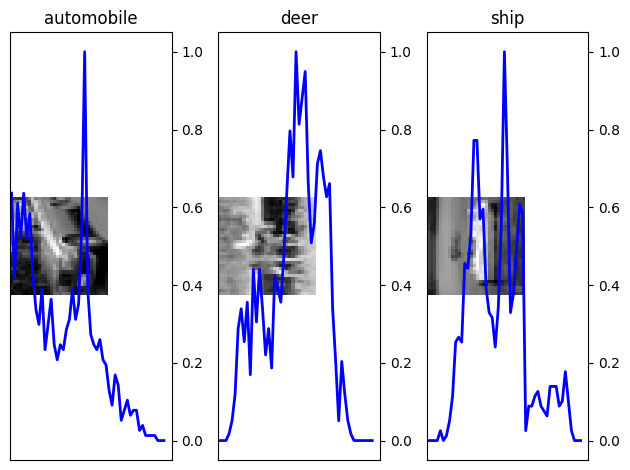

In [161]:
def plotImagesHist(targets, x, hists):
    fig, axes = plt.subplots(ncols=len(targets))
    for ax, (i, name) in zip(axes, targets.items()):
        samples = x[i]
        idx = np.random.choice(len(samples))
        # Display the image in grayscale
        ax.imshow(samples[idx], cmap="gray")

        # Overlay the histogram on a secondary y-axis
        ax_hist = ax.twinx()  # Create a secondary y-axis for the histogram
        ax_hist.plot(hists[i][idx]/np.max(hists[i][idx]), color="blue", lw=2)

        ax.axis("off")  # Turn off axis for the image

        ax.set_title(name)
    fig.tight_layout()
    plt.show()

plotImagesHist(target_labels, grayscale_images, histograms)

### Test batch

Read the test batch in file test batch. For the same classes as above, extract the 10 first images

In [186]:
batch_test = unpickle(os.path.join(data_dir, "test_batch"))
data_test = np.asarray(batch_test[b'data'])
labels_test = np.asarray(batch_test[b'labels'])
nTestSamples = 10

Read the test batch in file test batch. For the same classes as above, extract the 10 first images

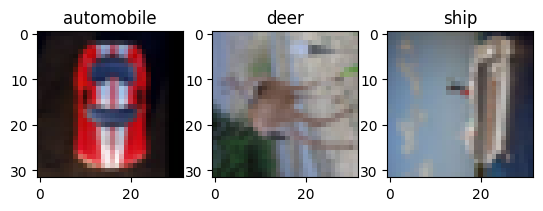

In [187]:
class_images_test = getNSamplesPerClass(target_labels, data_test, labels_test, nTestSamples)
plotRandomImages(target_labels, class_images_test)
# Convert each image in class_images to grayscale by taking the mean over all color channels
grayscale_images_test = {label: [np.mean(img, axis=-1) for img in imgs] for label, imgs in class_images_test.items()}

Calculate the histograms of all the images in the same way as above, using the same bins vector

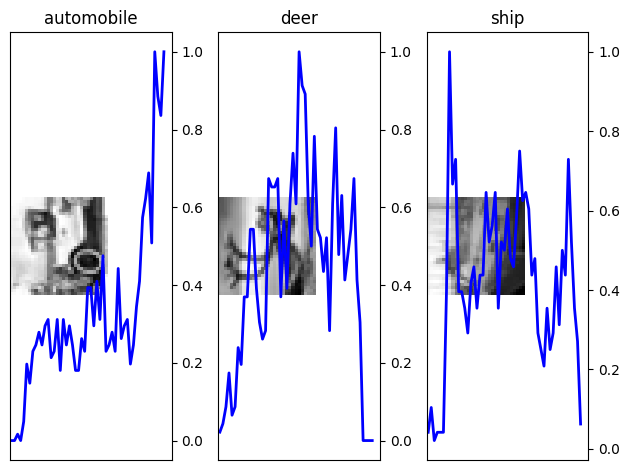

In [188]:
# Calculate and store histograms
histograms_test = {label: [calculate_histogram(img) for img in imgs] for label, imgs in grayscale_images_test.items()}
plotImagesHist(target_labels, grayscale_images_test, histograms_test)

Classify each image in the test set by finding its nearest neighbour in the training set. For each
test image:
1. Calculate the Euclidean (L2) distances of the histogram of the test image and the histogram
of every training image. If you have n training images, you should calculate n distances for
every test image.
2. Classify the test image by finding the minimum of the distances. Once you find the minimum
distance, the predicted class of the test image is the class of the nearest training image.

In [211]:
# Flatten training data
def predict(x_train, x_test):
    train_hists = np.concatenate(list(x_train.values()))
    train_labels = np.concatenate([[c_train] * len(hists) for c_train, hists in x_train.items()])

    # Classify test images
    predictions = []
    for c, hists_test in x_test.items():
        hists_test = np.array(hists_test)
        dists = np.linalg.norm(train_hists[None, :, :] - hists_test[:, None, :], axis=2)
        nearest_indices = np.argmin(dists, axis=1)
        predictions.extend((c, train_labels[idx]) for idx in nearest_indices)
    return predictions

In [217]:
# Calculate accuracy
predictions = predict(histograms, histograms_test)
correct_predictions = sum(1 for label, prediction in predictions if label == prediction)
accuracy = correct_predictions / len(predictions)

print(f"Accuracy: {accuracy:.2%}")

Accuracy: 60.00%


In [225]:
accuracies = []
for i in range(2, 256):
    bins=np.arange(0, i)
    histograms = {label: [calculate_histogram(img, bins=bins) for img in imgs] for label, imgs in grayscale_images.items()}
    histograms_test = {label: [calculate_histogram(img, bins=bins) for img in imgs] for label, imgs in grayscale_images_test.items()}
    predictions = predict(histograms, histograms_test)
    correct_predictions = sum(1 for label, prediction in predictions if label == prediction)
    accuracies.append(correct_predictions / len(predictions))



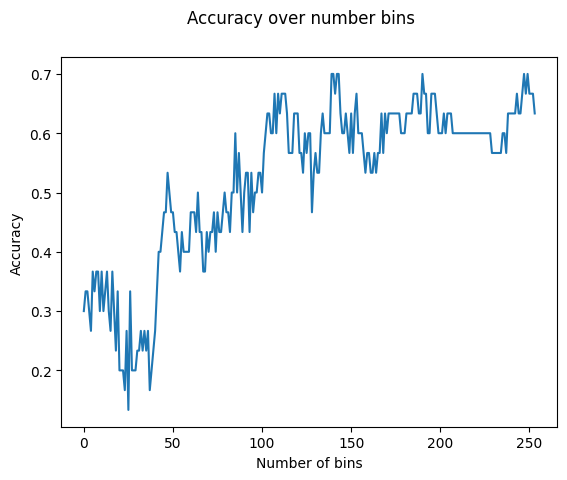

In [229]:
plt.plot(accuracies)
plt.suptitle("Accuracy over number bins")
plt.xlabel("Number of bins")
plt.ylabel("Accuracy")
plt.show()